# 1. Tweet sentiment extraction

## 1.1. The goal and metrics

The goal of this kaggle competition is to extract sentiment summarization from tweet texts which are denoted by sentiment type with neural,positive or negative. The data format is as following. The column "selected_text" is the target we should predict with the infomation of "text" and "setiment".

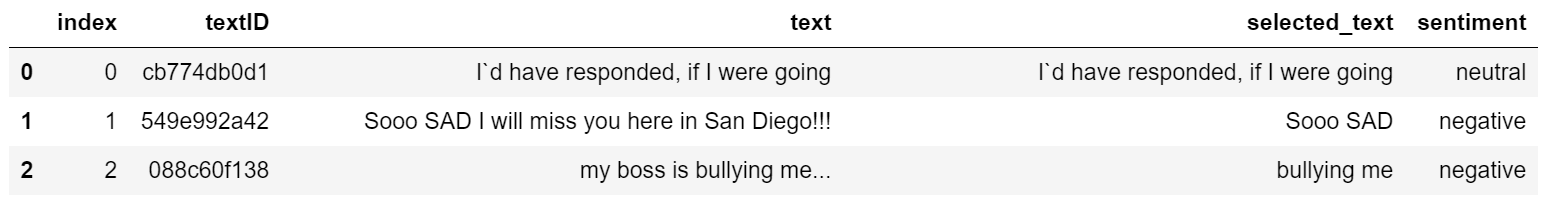


The metrics is [world level jaccard](http://en.wikipedia.org/wiki/Jaccard_index), The function of jaccard is as below:
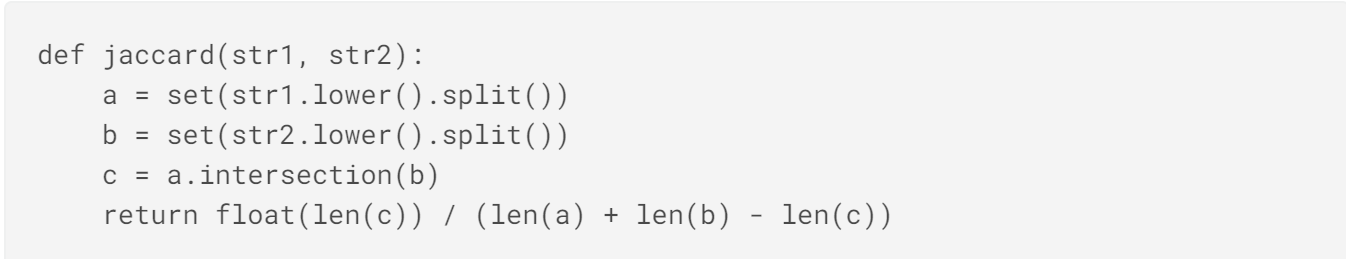

The overall metric is: 
$$score=\sum_{i=1}^n jaccard(gt_i,dt_i)$$
Where n is the number of examples in the dataset, $gt_i$ is the ith ground truth, $dt_i$ is the ith prediction.


## 1.2 The archetecture

In this notebook, I present a solution which build two_stage models to extract the sentiment. 

The first stage model is based on WordPiece level tokens. I apply Roberta transformer with a CNN layer on the top to predict the probabilities of the start and end index for the tokens in the sequence. I then build the second stage model based on character_level tokens to futhur compute the probilities of start and end index of sentiment summarization.

The frameworks I use are tensorflow and transfomer. And I use kaggle GPU to run my code. 

I am grateful that many people generously shared their excellent ideas and solutions. I learned a lot from this competition, and this solution borrowed largely from the following posts:

https://www.kaggle.com/khoongweihao/tse2020-roberta-cnn-random-seed-distribution

https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/159477
 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import math
import argparse
import pickle
import tokenizers
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers as L
from transformers import TFBertMainLayer,TFBertModel,TFBertPreTrainedModel,BertConfig,BertTokenizer
from transformers import TFRobertaModel, RobertaTokenizer,RobertaConfig
from transformers.modeling_tf_utils import get_initializer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=88888)

#First stage model arguments
parser.add_argument("--model_type", default="roberta", type=str)
parser.add_argument("--model_path", default="../input/tweet-senti-pretrained-roberta-cnn/", type=str)
parser.add_argument("--max_seq_length", default=96, type=int)
parser.add_argument("--train_batch_size", default=32, type=int)
parser.add_argument("--eval_batch_size", default=32, type=int)
parser.add_argument("--num_train_epochs", default=3, type=int)
parser.add_argument("--cv_splits", default=5, type=int)
parser.add_argument("--warmup", default=0.1, type=float)
parser.add_argument("--learning_rate", default=3e-5, type=float)
parser.add_argument("--epoches_1", default=3, type=float)

#Second stage model arguments
parser.add_argument("--max_char_length", default=150, type=int)
parser.add_argument("--cv_splits_2", default=5, type=int)
parser.add_argument("--learning_rate_2", default=4e-3, type=float)
parser.add_argument("--epoches_2", default=5, type=float)

args, _ = parser.parse_known_args()

In [ ]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    tf.random.set_seed(args.seed)

set_seed(args)

# 2. First stage model

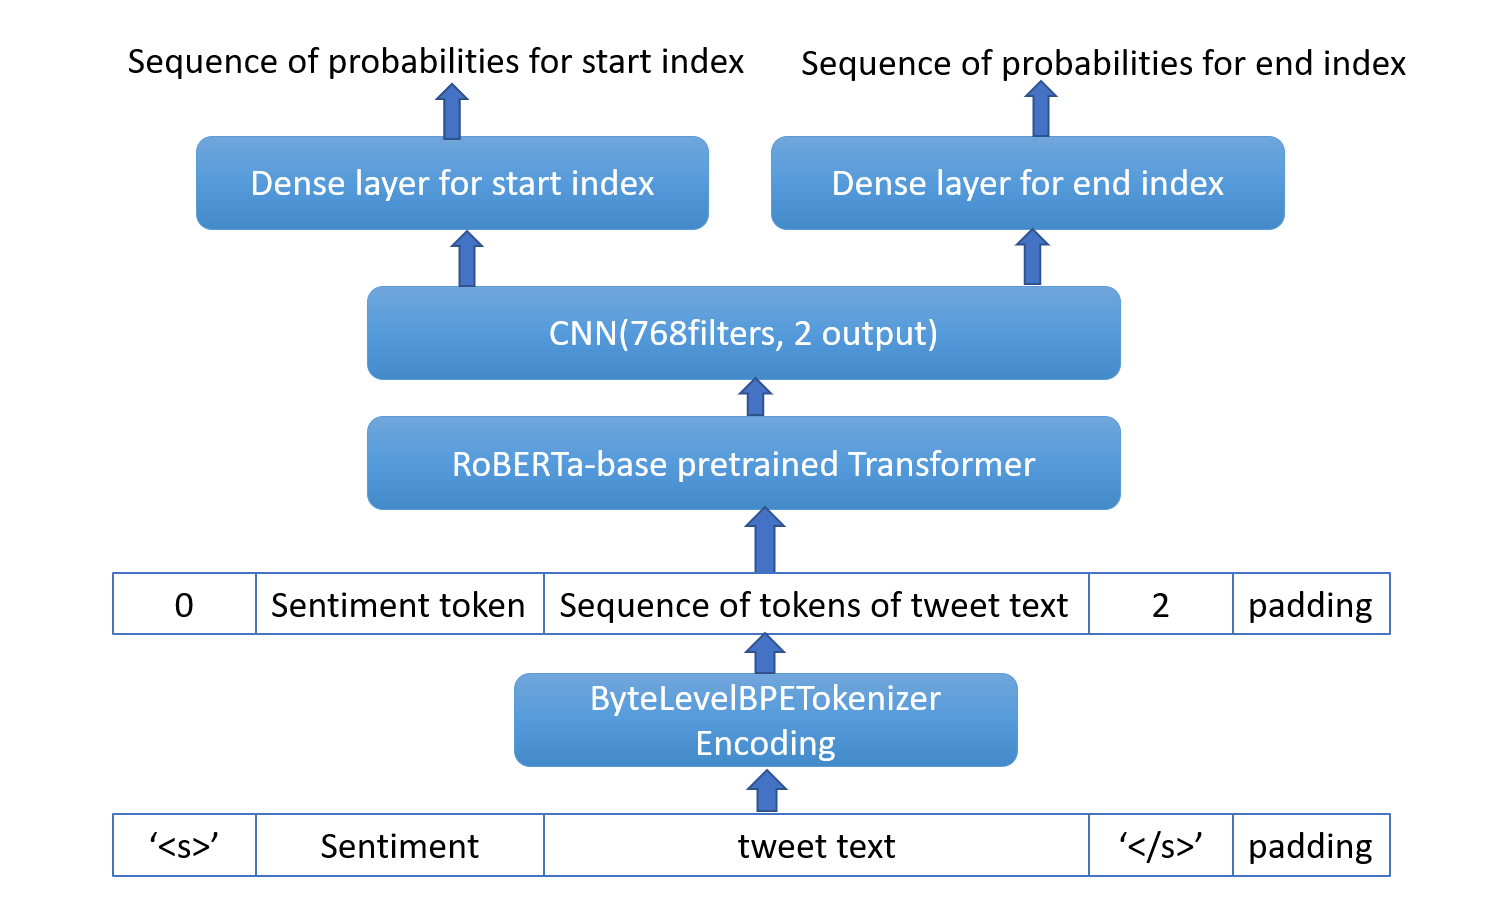


I tried bert_base, bert_large, Alber base, Albert large, RoBERTa large during building the WordPiece token level model. Ultimately, I choose RoBERTa_base as the transfomer for my first stage model. My choice was made based on two reasons. First, the jaccard value from outcome of the RoBERTa base transfomer is slightly better than other transfomers. Second, the computation speed is significently quicker than others. I think the Byte-Pair-Encoding of the RoBERTa helps get better results and remove the next sentence prediction objective in RoBERTa decreases the trainning time.

## 2.1 Prepare the data and quick EDA

Take a glimpse of the data. It is obviously that the lengh of targets for negative and positive tweets are much shortter than the neutral tweets. The length of the targets for neutral tweets is almost the same as the raw tweets. Let us feed this information and allow the model learning the pattern. 

In [ ]:
test_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
train_df=pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
train_df.dropna(inplace=True)
train_df=train_df.reset_index()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
f, axes = plt.subplots(1, 3,figsize=(15,6))
sns.countplot(x=train_df[train_df['sentiment']=='neutral']['text'].astype(str).str.split().str.len(),ax=axes[0])
sns.countplot(x=train_df[train_df['sentiment']=='positive']['text'].astype(str).str.split().str.len(),ax=axes[1])
sns.countplot(x=train_df[train_df['sentiment']=='negative']['text'].astype(str).str.split().str.len(),ax=axes[2])
axes[0].title.set_text('lenght of neutral')
axes[1].title.set_text('length of positive')
axes[2].title.set_text('length of negative')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
axes[1].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
axes[2].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
f, axes = plt.subplots(1, 3,figsize=(15,6))
sns.countplot(x=train_df[train_df['sentiment']=='neutral']['selected_text'].astype(str).str.split().str.len(),ax=axes[0])
sns.countplot(x=train_df[train_df['sentiment']=='positive']['selected_text'].astype(str).str.split().str.len(),ax=axes[1])
sns.countplot(x=train_df[train_df['sentiment']=='negative']['selected_text'].astype(str).str.split().str.len(),ax=axes[2])
axes[0].title.set_text('lenght of neutral sentiment')
axes[1].title.set_text('lenght of positive sentiment')
axes[0].title.set_text('lenght of neutral sentiment')

axes[2].title.set_text('lenght of neutral')
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
axes[1].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
axes[2].set_xticklabels(axes[0].get_xticklabels(), fontsize=8)
plt.tight_layout()

In [ ]:
#Load the data for first stage model
def load_data_roberta(df,tokenizer, is_train_eval):
    sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
    ct = df.shape[0]
    MAX_LEN_WORD=args.max_seq_length
    input_ids = np.ones((ct,MAX_LEN_WORD),dtype='int32')
    attention_mask = np.zeros((ct,MAX_LEN_WORD),dtype='int32')
    token_type_ids = np.zeros((ct,MAX_LEN_WORD),dtype='int32') #need it or not?
    start_tokens = np.zeros((ct,MAX_LEN_WORD),dtype='int32')
    end_tokens = np.zeros((ct,MAX_LEN_WORD),dtype='int32')
    offsets=[]
    tweets=[]

    for k in range(ct):
        text1 = " "+" ".join(df.loc[k,'text'].split()) 
        enc = tokenizer.encode(text1)
        sentiment_token = sentiment_id[df.loc[k,'sentiment']]
        input_ids[k,:len(enc.ids)+3] = [0, sentiment_token] + enc.ids + [2]
        attention_mask[k,:len(enc.ids)+3] = 1
        offsets.append([(0,0)]* 2 + enc.offsets + [(0,0)])
        tweets.append(text1)
                
        if is_train_eval:            
            chars = np.zeros((len(text1)))
            text2 = " ".join(df.loc[k,'selected_text'].split())
            # start index of selceted text in the raw text at char level
            start_idx = text1.find(text2) 
            chars[start_idx:start_idx+len(text2)]=1
            #add the white space before the beginning of selected text
            if text1[start_idx-1]==' ': 
                chars[start_idx-1] = 1         

            selected_toks_index = []
            for i,(a,b) in enumerate(enc.offsets):
                sm = np.sum(chars[a:b])
                if sm>0: selected_toks_index.append(i) 
            if len(selected_toks_index)>0:
                start_tokens[k,selected_toks_index[0]+2] = 1
                end_tokens[k,selected_toks_index[-1]+2] = 1
    
    if is_train_eval:           
        dataset={'input_ids':input_ids,
                 'attention_mask':attention_mask,
                 'token_type_ids':token_type_ids,
                 'start_tokens':start_tokens,
                 'end_tokens':end_tokens,
                 'tweets':tweets,
                 'offsets':offsets}

    #for pred
    else:
        dataset={'input_ids':input_ids,
                 'attention_mask':attention_mask,
                 'token_type_ids':token_type_ids,
                 'tweets':tweets,
                 'offsets':offsets}
            
    return dataset 

In [ ]:
model_path="../input/robertatransformer/roberta-base-tf_model.h5"
model_class=TFRobertaModel
config = RobertaConfig.from_pretrained("../input/robertatransformer/roberta-base-config.json")
tokenizer = tokenizers.ByteLevelBPETokenizer(vocab_file="../input/robertatransformer/roberta-base-vocab.json", 
                                            merges_file="../input/robertatransformer/roberta-base-merges.txt", 
                                            lowercase=True,
                                            add_prefix_space=True)

In [ ]:
trainset=load_data_roberta(train_df,tokenizer, is_train_eval=True) 
testset=load_data_roberta(test_df,tokenizer, is_train_eval=False) 

## 2.2 Build the RoBERTa transformer with one layer CNN on the top

For faster training time, I sorted the input dataset according to the text length. Thus, the data in the same batch has almost the same lengh, and I could pad them to the shortter sequence to decrease the process time for the batch. That is why there are two models in the following code. The "model" is for traning, and the "padded_model" is for predicting in which every batch has the same sequece length. I choose the categorical cross entropy function as the loss funciton and Adam as the optimizer. And since this is finetuning to a pretrained transfomer, I choose the learning rate as 3e-5 which is smaller than other model training. I also tried to apply learning rate scheduler to imprvoe the performance. But it didn't help significantly. So I kept the simple way.

In [ ]:
PAD_ID=1
lr=args.learning_rate
def build_model_cnn(model_class,model_path,config):
    MAX_LEN_WORD=args.max_seq_length
    ids = tf.keras.layers.Input((MAX_LEN_WORD,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN_WORD,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN_WORD,), dtype=tf.int32)
    padding = tf.cast(tf.equal(ids, PAD_ID), tf.int32)

    lens = MAX_LEN_WORD - tf.reduce_sum(padding, -1)
    max_len_word = tf.reduce_max(lens)
    ids_ = ids[:, :max_len_word]
    att_ = att[:, :max_len_word]
    tok_ = tok[:, :max_len_word]

    bertmodel = model_class.from_pretrained(model_path,config=config)
    x = bertmodel(ids_,attention_mask=att_,token_type_ids=tok_)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(768,2,padding='same')(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Dense(1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss=loss_fn,optimizer=optimizer)
    
    
    # this is required as `model.predict` needs a fixed size!
    x1_padded = tf.pad(x1, [[0, 0], [0, MAX_LEN_WORD - max_len_word]], constant_values=0.)
    x2_padded = tf.pad(x2, [[0, 0], [0, MAX_LEN_WORD - max_len_word]], constant_values=0.)
    
    padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
    return model, padded_model

In [ ]:
#loss function for first stage model
LABEL_SMOOTHING=0.1
def loss_fn(y_true, y_pred):
    # adjust the targets for sequence bucketing
    ll = tf.shape(y_pred)[1]
    y_true = y_true[:, :ll]
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss


In [ ]:
def save_weights(model, dst_fn):
    weights = model.get_weights()
    with open(dst_fn, 'wb') as f:
        pickle.dump(weights, f)

In [ ]:
def load_weights(model, weight_fn):
    with open(weight_fn, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    return model


In [ ]:
#The metrics to measure the perfomance of the predict results for both stage1 and stage2 model
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## 2.3 Training the model with k-Folds

After some experiments, I choose 5 folds and 3 epoches for every fold to train the model. The result turns out not too bad. The local CV jaccard is 0.705, and the LB is 0.712.

In [ ]:
#def train_pred_cv():
jac = []; 
VER='v0'; 
DISPLAY=1
n_splits=args.cv_splits
lr=args.learning_rate
MAX_LEN=args.max_seq_length
n_best=3

input_ids=trainset['input_ids']
attention_mask=trainset['attention_mask']
token_type_ids=trainset['token_type_ids']
start_tokens=trainset['start_tokens']
end_tokens=trainset['end_tokens']

input_ids_test=testset['input_ids']
attention_mask_test=testset['attention_mask']
token_type_ids_test=testset['token_type_ids']

ct_train=input_ids.shape[0]
ct_test=input_ids_test.shape[0]
oof_start = np.zeros((ct_train,MAX_LEN))
oof_end = np.zeros((ct_train,MAX_LEN))
preds_start = np.zeros((ct_test,MAX_LEN))
preds_end = np.zeros((ct_test,MAX_LEN))

jac_valiation=np.zeros((ct_train,))
out_of_range=[]
abnormal=[]

skf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=args.seed)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train_df.sentiment.values)):
    
    print('### FOLD %i'%(fold+1))
    
    K.clear_session()
    #set_seed(args)
    model, padded_model = build_model_cnn(model_class,model_path,config)
    
   
    inpT = [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]]
    targetT = [start_tokens[idxT,], end_tokens[idxT,]]
    inpV = [input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]]
    targetV = [start_tokens[idxV,], end_tokens[idxV,]]
        
    # sort the validation data
    shuffleV = np.int32(sorted(range(len(inpV[0])), key=lambda k: (inpV[0][k] == PAD_ID).sum(), reverse=True))
    inpV = [arr[shuffleV] for arr in inpV]
    targetV = [arr[shuffleV] for arr in targetV]
    weight_fn = f'roberta-base-{fold+1}.h5'

    for epoch in range(1, args.num_train_epochs + 1):
        BATCH_SIZE=args.train_batch_size
        # sort and shuffle: We add random numbers to not have the same order in each epoch
        shuffleT = np.int32(sorted(range(len(inpT[0])), key=lambda k: (inpT[0][k] == PAD_ID).sum() + np.random.randint(-3, 3), reverse=True))
        # shuffle in batches, otherwise short batches will always come in the beginning of each epoch
        num_batches = math.ceil(len(shuffleT) / BATCH_SIZE)
        batch_inds = np.random.permutation(num_batches)
        shuffleT_ = []
        for batch_ind in batch_inds:
            shuffleT_.append(shuffleT[batch_ind * BATCH_SIZE: (batch_ind + 1) * BATCH_SIZE])
        shuffleT = np.concatenate(shuffleT_)
        # reorder the input data
        inpT = [arr[shuffleT] for arr in inpT]
        targetT = [arr[shuffleT] for arr in targetT]        
        model.fit(inpT, targetT, 
            epochs=epoch, initial_epoch=epoch - 1, batch_size=BATCH_SIZE, verbose=DISPLAY, 
                  callbacks=[],validation_data=(inpV, targetV), shuffle=False)  
    
    save_weights(model, weight_fn)
        
    print('Loading model for validation and pred...')
        # model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    #load_weights(model, weight_fn)
    padded_model.set_weights(model.get_weights()) 

    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = padded_model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)

    print('Predicting Test...')
    preds = padded_model.predict([input_ids_test,attention_mask_test,token_type_ids_test],verbose=DISPLAY)
    preds_start+=preds[0]/n_splits
    preds_end+=preds[1]/n_splits

    fold_jac_val=[]
    for k in idxV:        
        a= np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])        
        if a>b:
            st=train_df.loc[k,'text']
        else:
            text1 = " "+" ".join(train_df.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-2:b-1])
        jac_val=jaccard(st,train_df.loc[k,'selected_text'])
        fold_jac_val.append(jac_val)
    jac.append(np.mean(fold_jac_val))
    print(f'>>>> FOLD {fold+1} Jaccard ={np.mean(fold_jac_val)}')   

In [ ]:
print(f'The CV jaccard is {np.mean(jac)}')

## 2.4 Predict the test set and train set with pretrained first level model

In [ ]:
roberta_models=["roberta-base-1.h5",
                "roberta-base-2.h5",
                "roberta-base-3.h5",
                "roberta-base-4.h5",
                "roberta-base-5.h5"]

In [ ]:
MAX_LEN_WORD=args.max_seq_length
DISPLAY=1
                                    
input_ids_test=testset['input_ids']
attention_mask_test=testset['attention_mask']
token_type_ids_test=testset['token_type_ids']
preds_test_start = np.zeros((ct_test,MAX_LEN_WORD))
preds_test_end = np.zeros((ct_test,MAX_LEN_WORD))

input_ids_train=trainset['input_ids']
attention_mask_train=trainset['attention_mask']
token_type_ids_train=trainset['token_type_ids']
preds_oof_start = np.zeros((ct_train,MAX_LEN_WORD))
preds_oof_end = np.zeros((ct_train,MAX_LEN_WORD))

In [ ]:
model_number=len(roberta_models)
for i in range(model_number):
    print(f"predict roberta model----{i+1}")
    K.clear_session()
    weight_fn=roberta_models[i]
    _, padded_model = build_model_cnn(model_class,model_path,config)   
    load_weights(padded_model, weight_fn)
    preds_test = padded_model.predict([input_ids_test,attention_mask_test,token_type_ids_test],verbose=DISPLAY)
    preds_test_start+=preds_test[0]/model_number
    preds_test_end+=preds_test[1]/model_number
    
    preds_oof = padded_model.predict([input_ids_train,attention_mask_train,token_type_ids_train],verbose=DISPLAY)
    preds_oof_start+=preds_oof[0]/model_number
    preds_oof_end+=preds_oof[1]/model_number

## 2.5 Convert the WordPiece level probabilities to char level probabilities

The prediction from first level model is based on word peice level tokens. In order to feed this prediction to the second level model which is based on charecter_level tokens, I convert the prediction to character level. The following is a example：

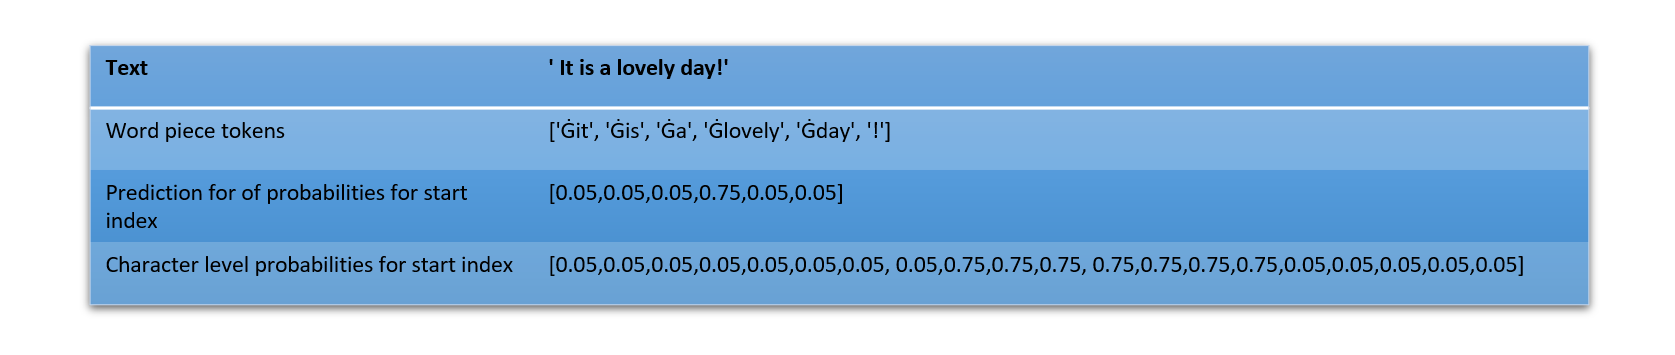

In [ ]:
def token_level_to_char_level(text, offsets, preds):
    probas_char = np.zeros(len(text))
    for i, offset in enumerate(offsets):
        if offset[0] or offset[1]:
            probas_char[offset[0]:offset[1]] = preds[i]
    return probas_char

In [ ]:
tweets_train=trainset['tweets']
offsets_train=trainset['offsets']
probas_train_start=[]
probas_train_end=[]


for idx, tweet in enumerate(tweets_train):
    probas_train_start.append(token_level_to_char_level(tweet, offsets_train[idx], preds_oof_start[idx]))
    probas_train_end.append(token_level_to_char_level(tweet, offsets_train[idx], preds_oof_end[idx]))


In [ ]:
tweets_test=testset['tweets']
offsets_test=testset['offsets']
probas_test_start=[]
probas_test_end=[]
for idx, tweet in enumerate(tweets_test):
    probas_test_start.append(token_level_to_char_level(tweet, offsets_test[idx], preds_test_start[idx]))
    probas_test_end.append(token_level_to_char_level(tweet, offsets_test[idx], preds_test_end[idx]))

In [ ]:
with open('char_pred_train_start.pkl', 'wb') as handle:
    pickle.dump(probas_train_start, handle)
with open('char_pred_train_end.pkl', 'wb') as handle:
    pickle.dump(probas_train_end, handle)

# 3. Second stage model

I then build a second level model to futhur compute the probility of start and end index of sentiment summary. This model is based on character_level tokens, and it has three inputs:
<br>
1) The output of first stage model. 
<br>
2) The sequence of character_level tokens of tweets.
<br>
3) The sentiment type(neutral, positive, negative)

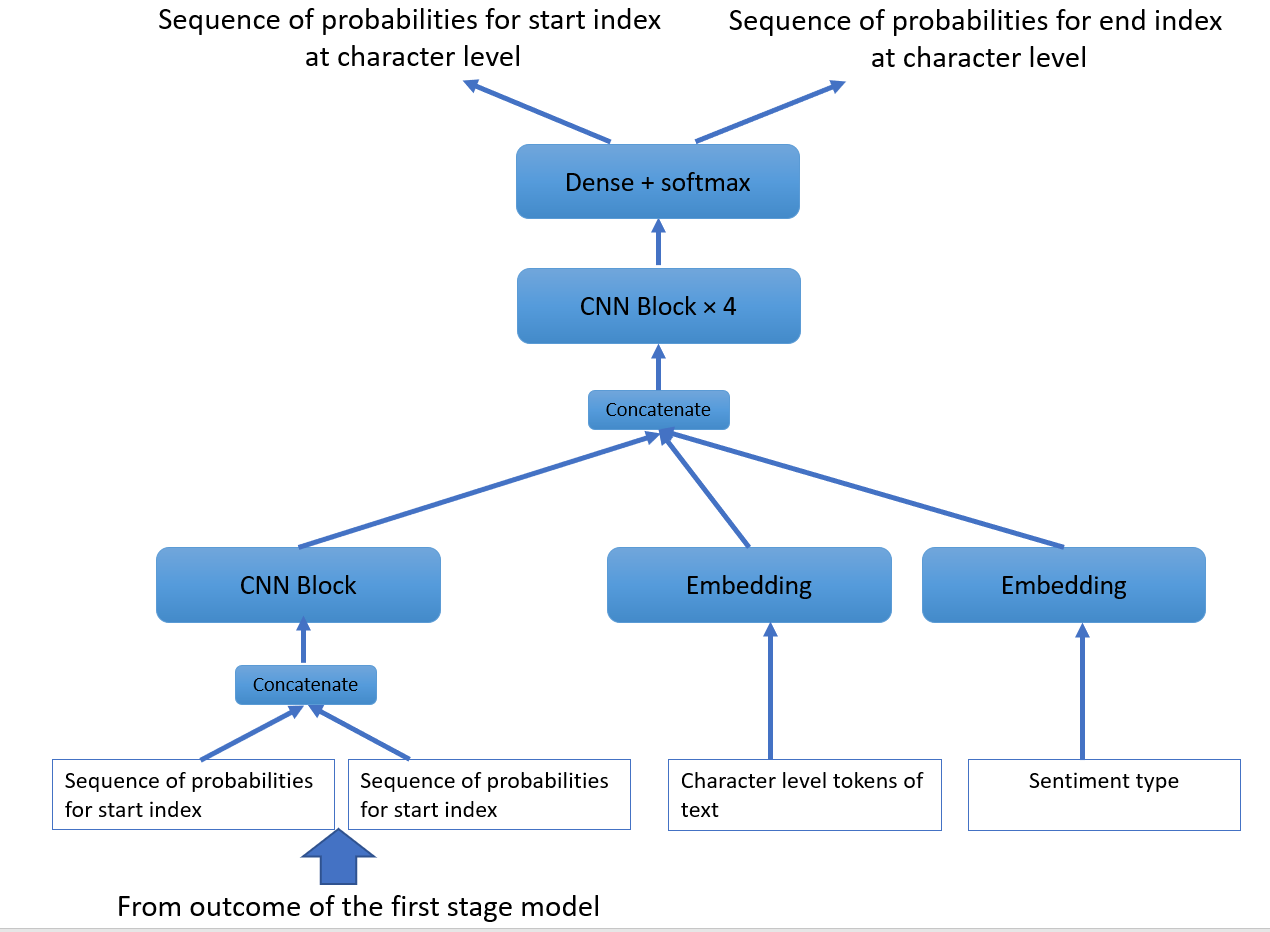

## 3.1 Prepre the data for second stage model



In [ ]:
#convert text to char-level tokens
tokenizer_char = Tokenizer(num_words=None, char_level=True, oov_token='UNK', lower=True)
tokenizer_char.fit_on_texts(train_df['text'].values)
len_voc = len(tokenizer_char.word_index) + 1

X_train = tokenizer_char.texts_to_sequences(train_df['text'].values)
X_test = tokenizer_char.texts_to_sequences(test_df['text'].values)

In [ ]:
def get_start_end_string(text, selected_text):
    len_selected_text = len(selected_text)
    idx_start, idx_end = 0, 0
    
    candidates_idx = [i for i, e in enumerate(text) if e == selected_text[0]]
    for idx in candidates_idx:
        if text[idx : idx + len_selected_text] == selected_text:
            idx_start = idx
            idx_end = idx + len_selected_text-1
            break
    assert text[idx_start: idx_end+1] == selected_text, f'"{text[idx_start: idx_end+1]}" instead of "{selected_text}" in "{text}"'

    char_targets = np.zeros(len(text))
    char_targets[idx_start: idx_end+1] = 1
    
    return idx_start, idx_end

In [ ]:
def load_data_second_model(df, X, char_start_probas, char_end_probas, max_len_char, train=True):
    
    ct=len(df)
    X = pad_sequences(X, maxlen=max_len_char, padding='post', truncating='post')

    start_probas = np.zeros((ct, max_len_char), dtype=float)
    for i, p in enumerate(char_start_probas):
        len_ = min(len(p), max_len_char)
        start_probas[i, :len_] = p[:len_]
    start_probas=np.expand_dims(start_probas, axis=2)

    end_probas = np.zeros((ct, max_len_char), dtype=float)
    for i, p in enumerate(char_end_probas):
        len_ = min(len(p), max_len_char)
        end_probas[i, :len_] = p[:len_]
    end_probas=np.expand_dims(end_probas, axis=2)

    sentiments_list = ['positive', 'neutral', 'negative']

    texts = df['text'].values
    selected_texts = df['selected_text'].values if train else [''] * len(df)
    sentiments = df['sentiment'].values
    sentiments_input = [[sentiments_list.index(s)]*max_len_char for s in sentiments]


    if train:
        start_idx = np.zeros((ct,max_len_char),dtype='int32')
        end_idx = np.zeros((ct,max_len_char),dtype='int32')
        for i, (text, sel_text) in enumerate(zip(df['text'].values, df['selected_text'].values)):
            start, end = get_start_end_string(text, sel_text.strip())
            start_idx[i,start]=1
            end_idx[i,end]=1
    else:
        start_idx = [0] * len(df)
        end_idx = [0] * len(df)

    dataset= {
        'ids': X, #np.array(len,max_len_char)
        'probas_start': start_probas,  #np.array(len,max_len_char,1)
        'probas_end': end_probas, #np.array(len,max_len_char,1)
        'target_start': start_idx, #np.array
        'target_end': end_idx, #np.array
        'text': texts, #pd.series
        'selected_text': selected_texts, #pd.series
        'sentiment': sentiments,
        'sentiment_input': np.array(sentiments_input),#list
        }
        
    return dataset

In [ ]:
char_dataset_train=load_data_second_model(train_df, 
                                          X_train, 
                                          probas_train_start, 
                                          probas_train_end, 
                                          max_len_char=args.max_char_length, 
                                          train=True)
char_dataset_test=load_data_second_model(test_df, 
                                          X_test, 
                                          probas_test_start, 
                                          probas_test_end, 
                                          max_len_char=args.max_char_length, 
                                          train=False)

## 3.2 Build and train the character level model (CNN)

In this step, I still choose the categorical_crossentropy function with label_smoothing as the loss function. And I train the model with 5 folds cross validation. Every fold has 5 epoches. The CV jaccard is around 0.78 and the LB result is around 0.728. I expected the CV was close to the LB. What caused the big difference between them? I guess the trainset was trained by 2 stages that might be the reason why the validation data got much better score.    

In [ ]:
LABEL_SMOOTHING=0.1
def loss_fn_2(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred,
        from_logits=False, label_smoothing=LABEL_SMOOTHING)
    loss = tf.reduce_mean(loss)
    return loss

In [ ]:
class ConvBlock(L.Layer):
  def __init__(self,out_dim,kernel_size,padding="same"):
    super(ConvBlock, self).__init__()
    self.conv=L.Conv1D(out_dim,kernel_size, padding=padding)
    self.bn=L.BatchNormalization()
            
  def call(self, inputs):
    x=self.conv(inputs)
    x=self.bn(x)
    x=tf.keras.activations.relu(x)
    return x

In [ ]:
class Logits(L.Layer):
    def __init__(self,dim1=32,dim2=2):
        super(Logits, self).__init__()
        self.dense1=L.Dense(dim1,activation='relu')
        self.dense2=L.Dense(dim2)

    def call(self, inputs):
        x=self.dense1(inputs)
        x=self.dense2(x)

        return x

In [ ]:
class CharCNN(tf.keras.Model):

    def __init__(self,len_voc,cnn_dim=32, char_embed_dim=16, sent_embed_dim=16, 
               proba_cnn_dim=16, kernel_size=3,max_len_char=args.max_char_length):
        super(CharCNN, self).__init__()
        self.CharEmbedding = L.Embedding(input_dim=len_voc, output_dim=char_embed_dim)
        self.SentimentEmbedding = L.Embedding(input_dim=3, output_dim=sent_embed_dim)
        self.ProbasCNN = ConvBlock(proba_cnn_dim,kernel_size)
        self.CNN1=ConvBlock(cnn_dim,kernel_size)
        self.CNN2=ConvBlock(cnn_dim*2,kernel_size)
        self.CNN3=ConvBlock(cnn_dim*4,kernel_size)
        self.CNN4=ConvBlock(cnn_dim*8,kernel_size)
        self.Dropout = L.Dropout(0.5)
        self.dense_logits=Logits(32,2)
        

    def call(self, inputs):
        char_ids,sentiment,start_probas,end_probas=inputs
        probas = tf.concat([start_probas, end_probas], -1) #(b,max_len_char,2)
        probas_fts = self.ProbasCNN(probas) 
        #print("probas_fts",probas_fts.shape)    
        char_fts = self.CharEmbedding (char_ids) #(b,max_len_char,16)
        #print("char_fts",char_fts.shape)
        sentiment_fts = self.SentimentEmbedding(sentiment) #(b,max_len_char,16)
        #print("sentiment_fts",sentiment_fts.shape)

        x = tf.concat([char_fts, sentiment_fts, probas_fts], -1) 
        features = self.CNN1(x)
        features = self.CNN2(features)
        features = self.CNN3(features)
        features = self.CNN4(features)    
        #print("features",features.shape)

        logits=self.Dropout(features)
        logits=self.dense_logits(logits) 
        #print("logits",logits.shape)

        start_logits, end_logits = logits[:, :, 0], logits[:, :, 1]
        start_logits= tf.keras.activations.softmax(start_logits)
        end_logits= tf.keras.activations.softmax(end_logits)
        #print("start_logits",start_logits.shape)

        return start_logits,end_logits

In [ ]:
inpTest=[char_dataset_test['ids'],
           char_dataset_test['sentiment_input'],
           char_dataset_test['probas_start'],
           char_dataset_test['probas_end']]

In [ ]:
n_splits=args.cv_splits_2
char_pred_oof_start=np.zeros((ct_train,args.max_char_length))
char_pred_oof_end=np.zeros((ct_train,args.max_char_length))
char_pred_test_start=np.zeros((ct_test,args.max_char_length))
char_pred_test_end=np.zeros((ct_test,args.max_char_length))
jac_2=[]
splits = list(StratifiedKFold(n_splits=n_splits).split(X=train_df, y=train_df['sentiment']))
for i, (train_idx, val_idx) in enumerate(splits):
    print("-----------------------------------------------------------------------")
    print(f"start train fold---{i+1}")
    inp_train=[char_dataset_train['ids'][train_idx],
               char_dataset_train['sentiment_input'][train_idx],
               char_dataset_train['probas_start'][train_idx],
               char_dataset_train['probas_end'][train_idx]]
    target_train=[char_dataset_train['target_start'][train_idx],char_dataset_train['target_end'][train_idx]]
    
    inp_val=[char_dataset_train['ids'][val_idx],
               char_dataset_train['sentiment_input'][val_idx],
               char_dataset_train['probas_start'][val_idx],
               char_dataset_train['probas_end'][val_idx]]
    target_val=[char_dataset_train['target_start'][val_idx],char_dataset_train['target_end'][val_idx]]
    model=CharCNN(len_voc)
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate_2)
    model.compile(loss=loss_fn_2,optimizer=optimizer)
    model.fit(inp_train, target_train, epochs=args.epoches_2, batch_size=128, verbose=1, 
              validation_data=(inp_val,target_val),
                  callbacks=[])
    print('preditc the oof')
    pred_val_start,pred_val_end=model.predict(inp_val,batch_size=128, verbose=1, callbacks=[])
    char_pred_oof_start[val_idx]=pred_val_start
    char_pred_oof_end[val_idx]=pred_val_end
    print("calcuate the jaccard for valset")
    fold_jac=[]
    for k in val_idx:
        a=np.argmax(char_pred_oof_start[k,])
        b=np.argmax(char_pred_oof_end[k,])
        orig_text=char_dataset_train['text'][k,]
        orig_selected=char_dataset_train['selected_text'][k,]
        if a>b: 
            pred_selected=orig_text
        else:            
            pred_selected=orig_text[a:b+1]
        jac_val=jaccard(pred_selected,orig_selected)
        fold_jac.append(jac_val)
    jac_2.append(fold_jac)
    print("fold jac is:", np.mean(fold_jac))
        
    print('predict the testset')
    pred_test_start,pred_test_end=model.predict(inpTest,batch_size=128, verbose=1, callbacks=[])
    char_pred_test_start+=pred_test_start/n_splits
    char_pred_test_end+=pred_test_end/n_splits

In [ ]:
print(f'The mean Jaccard value is {np.mean(jac_2)}')

## 3.3 Predict the testset and convet probabilities of start and end index to target string

In [ ]:
def convert_prob_to_string(dataset, pred_start, pred_end):
    ct=len(dataset['text'])
    pred=[]
    for k in range(ct):        
        start_idx=np.argmax(pred_start[k])
        end_idx=np.argmax(pred_end[k])
        if start_idx>end_idx:
            pred_selected_text=dataset['text'][k]
        else:
            pred_selected_text=dataset['text'][k][start_idx:end_idx+1]
        pred.append(pred_selected_text.strip())
    return pred      

In [ ]:
pred=convert_prob_to_string(char_dataset_test,char_pred_test_start, char_pred_test_end)
test_df['selected_text']=pred
test_df.to_csv('submission.csv',columns=['textID','selected_text'], index=False)


In [ ]:
test_df.sample(10)

# 4. Some thoughts

As I previously mentioned, I have tried to apply BERT and Albert transformer to the first stage model and it didn't work well. At this point, I am wondering that training variety of models and emsembling the results should have improved the overall score. 

Besides, do more experiements with learning rate, optimizer should have helped to boost the score.

Participating in this competition took quite a few efforts, but I gained many hands-on skills and state_of_art technologies in the field of NLP and have a lot of fun.
